# Inteligencia Artificial
# Clase 7 - Introducción a Redes Neuronales

En esta práctica, construiremos nuestra primera red neuronal utilizando `Numpy` y la entrenaremos para que aprenda a clasificar imágenes de dígitos escritos a mano. Para ello, definiremos algunas funciones que nos permitan:

1. Inicializar el modelo
2. Realizar el proceso de *forward propagation* computando la salida de cada nodo y su activación
3. Hacer las predicciones y calcular una métrica de error
4. Actualizar los pesos y sesgos con *backpropagation*

El código de esta notebook se basa en la implementación del libro [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/), de Michael A. Nielsen (2015).

En lo cotidiano, uno trabaja con *frameworks* específicos de *deep learning*, como `TensorFlow` o `Keras`, donde las distintas arquitecturas de red y la implementación del proceso de aprendizaje ya están resueltas, por lo que no tendremos que preocuparnos por construir desde cero nuestros modelos. Sin embargo, adentrarse en el interior de los algoritmos de inteligencia artificial nos permite ganar una mayor comprensión acerca de cómo funcionan, cuáles son sus alcances y, a su vez, sus limitaciones.

In [1]:
import numpy as np
import random
import pickle
import gzip

import matplotlib.pyplot as plt
%matplotlib inline

## Clasificando imágenes de dígitos escritos a mano

El dataset con el que trabajaremos es un dataset muy difundido, que suele utilizarse como punto de partida para comenzar a estudiar *deep learning*. Originalmente, fue publicado por el National Institute of Standards and Technology (NIST) de Estados Unidos, de ahí que se conozca con el nombre de NIST dataset (o MNIST, en su versión modificada).

Comenzamos leyendo un archivo que contiene los datos, ya previamente separados en los conjuntos de entrenamiento, validación y testeo:

In [2]:
f = gzip.open('mnist.pkl.gz', 'rb')
tr_d, va_d, te_d = pickle.load(f, encoding="latin1")
f.close()

Cada set de datos está estructurado en tuplas con dos elementos: el primero corresponde al conjunto de imágenes y el segundo, a sus respectivas etiquetas. Vemos la shape de los elementos del set de entrenamiento:

In [3]:
tr_d[0].shape

(50000, 784)

In [4]:
tr_d[1].shape

(50000,)

Contamos con 50000 imágenes de entrenamiento, cada una con 784 (28 x 28) píxeles en total. Visualizamos algunos ejemplos con sus etiquetas asociadas:

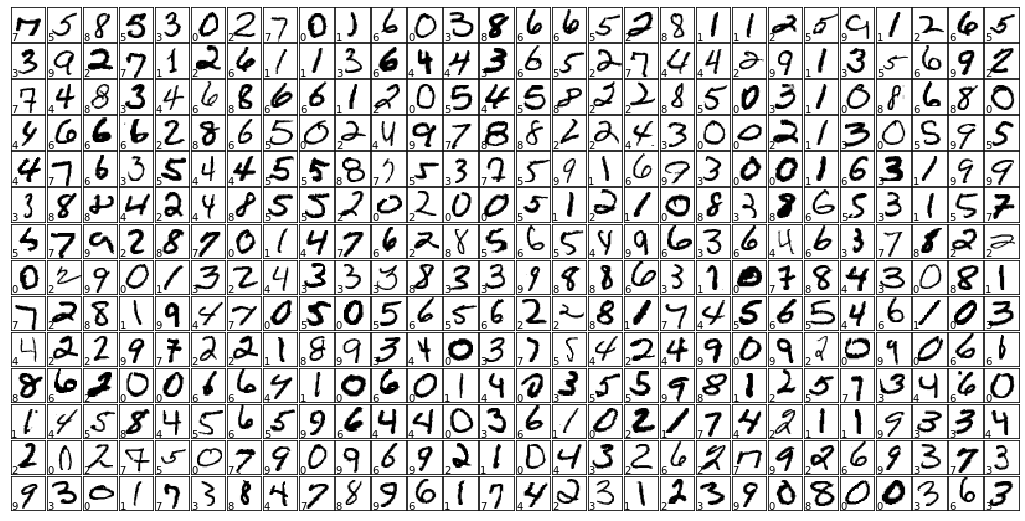

In [5]:
# Visualizamos algunas de las imágenes contenidas en el dataset
fig = plt.figure(figsize=(14, 14))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Graficamos algunos dígitos elegidos al azar
for i, j in enumerate(np.random.choice(tr_d[0].shape[0], 392)):
    ax = fig.add_subplot(28, 28, i + 1, xticks=[], yticks=[]) # Cada imagen tiene un tamaño de 28 x 28 pixels
    ax.imshow(tr_d[0][j].reshape((28,28)), cmap=plt.cm.binary,
              interpolation='nearest') # imshow permite generar imágenes a partir de arrays de Numpy
    ax.text(0, 27, str(tr_d[1][j]), fontsize=10) # Etiquetamos cada imagen con el target

La tarea consiste, entonces, en entrenar una red neuronal para clasificar estas imágenes de dígitos escritos a mano. Comenzaremos explorando una red con una sola capa oculta.

La metodología general para construir una red neuronal es:

1. Definir la arquitectura de la red neuronal: cantidad de unidades de entrada, cantidad de capas ocultas y unidades por capa y cantidad de unidades de salida.
2. Inicializar los parámetros del modelo.
3. Loop:
    - Implementar *forward propagation*
    - Calcular el error
    - Implementar *backpropagation* para obtener los gradientes
    - Actualizar los parámetros (descenso del gradiente)

Vamos a construir funciones auxiliares para ejecutar los pasos 1-3 y luego las integraremos en una clase, `Network`, que nos permitirá construir y entrenar distintas redes neuronales.

Comenzamos definiendo una función para inicializar la arquitectura de la red y sus pesos y sesgos:

In [6]:
def __init__(self, sizes, cost):
    """
    La lista ``sizes`` contiene el número de neuronas en cada capa capa de la red neuronal.
    Por ejemplo, si la lista es [2, 3, 1], entonces sería una red de tres capas,
    la primera con 2 neuronas, la segunda, con 3 neuronas y la tercera, con 1 neurona.
    Los pesos y sesgos de la red son inicializados aleatoriamente, usando una distribución Gaussiana
    con media 0 y varianza 1. Se asume que la primera capa es la capa de entrada y, por convención,
    no se establecerá ningún sesgo para esas neuronas, ya que los sesgos son utilizados en el cálculo de
    las salidas de capas posteriores.
    El argumento ``cost`` define qué función de costo se utilizará para entrenar la red.
    """
    self.num_layers = len(sizes)
    self.sizes = sizes
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    self.weights = [np.random.randn(y, x)
                    for x, y in zip(sizes[:-1], sizes[1:])]
    self.cost = cost

Cada neurona de nuestra red se encarga de computar una combinación lineal de todos los datos de entrada, que en cada capa oculta son simplemente los datos de salida de la capa previa, para luego activarla utilizando alguna función no lineal. En este caso, utilizaremos la función sigmoidea como función de activación. 

<img src="http://neuralnetworksanddeeplearning.com/images/tikz17.png"/>

Si llamamos $a^l_j$ a la activación de la neurona $j$ de la capa $l$, $w^l_{jk}$ al peso de la conexión entre la neurona $k$ en la capa $(l−1)$ y la neurona $j$ en la capa $l$, $b^l_j$ al sesgo de la neurona $j$ de la capa $l$ y usamos $\sigma$ para denotar a la función sigmoidea, podemos expresar la activación de cada neurona como:

$$ a^{l}_j = \sigma( \sum_k w^{l}_{jk} a^{l-1}_k + b^l_j ) $$

Esta ecuación, que define el proceso de *feedforward* o *forward propagation* de una red neuronal, puede ser reescrita en términos matriciales como:

$$ a^{l} = \sigma(w^l a^{l-1}+b^l) $$

A continuación, definimos dos funciones que nos permitirán propagar la información desde la capa de *input* de la red hacia la capa de *output*:

In [7]:
def sigmoid(z):
    """La función sigmoidea."""
    return 1.0/(1.0 + np.exp(-z))

def feedforward(self, a):
    """Retorna el output de la red si ``a`` es el input."""
    for w, b in zip(self.weights, self.biases):
        a = sigmoid(np.dot(w, a) + b)
    return a

¡Genial! Ya contamos con las funciones que nos van a permitir hacer fluir los datos a lo largo de toda la red para generar predicciones.

Ahora bien, lo que nos gustaría es contar con un algoritmo que nos permita encontrar los pesos y sesgos correctos para que la predicción de la red se aproxime a las verdaderas etiquetas $y$ de todas las entradas de entrenamiento $x$. Para cuantificar qué tan bien estamos logrando este objetivo, precisamos definir una función de costo. Como primera aproximación, nuestra función de costo será el error cuadrático medio, definido como:

$$ C(w,b) = \frac{1}{2n} \sum_x \| y(x) - a\|^2 $$

donde, $w$ denota la colección de todos los pesos en la red, $b$, todos los sesgos, $n$ es el número total de entradas de entrenamiento, $a$ es el vector de salidas de la red cuando $x$ es entrada, y la suma es sobre todas las entradas de entrenamiento, $x$.

> **Nota**: la multiplicación por $ \frac{1}{2} $ es para facilitar los cálculos que se hagan con la derivada de esta función de costo.

```python
def fn(a, y):
    """Retorna el costo asociado con un output ``a`` y el output deseado ``y``."""
    return 0.5 * np.linalg.norm(a - y)**2
```

Sabremos que el proceso de aprendizaje de nuestra red está funcionando correctamente si logramos minimizar $ C(w,b) $. Dicho de otra forma, queremos encontrar un conjunto de pesos y sesgos que hagan que el costo sea lo más pequeño posible. Lo haremos usando un algoritmo conocido como descenso de gradiente:

$$ w_k \rightarrow w_k' = w_k-\eta \frac{\partial C}{\partial w_k} $$
$$ b_l \rightarrow b_l' = b_l-\eta \frac{\partial C}{\partial b_l} $$

donde $ \eta $ es la *learning rate* o tasa de aprendizaje del modelo, $ \frac{\partial C}{\partial w_k} $ es la derivada parcial de $ C $ con respecto a $ w_k $ y $ \frac{\partial C}{\partial b_l} $ es la derivada parcial de $ C $ con respecto a $ b_l $.

Intuitivamente, el descenso de gradiente consiste en actualizar iterativamente los pesos y sesgos de la red para que el costo disminuya en cada iteración. La dirección de la actualización será la contraria a la indicada por $ \frac{\partial C}{\partial w_k} $ y $ \frac{\partial C}{\partial b_l} $, y la velocidad de la actualización queda determinada por la *learning rate*, un hiperparámetro crucial del aprendizaje de una red neuronal. Podemos apreciar cómo se comporta el algoritmo de descenso de gradiente con una buena tasa de aprendizaje (convergente) y con una mala tasa de aprendizaje (divergente) en estas imágenes:

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">

Así como el flujo de la información en una red se produce capa a capa, desde el *input* hasta el *output*, la actualización de los pesos y sesgos también se da capa a capa, pero en sentido inverso, es decir, desde la capa de salida hacia la capa de entrada. El algoritmo que actualiza los pesos y sesgos guiado por el descenso de gradiente desde la última capa de una red hasta la primera se conoce como *backpropagation*, ya que retropropaga el error desde el *output* hacia el *input* buscando hacer las modificaciones pertinentes para corregirlo.

Para realizar la *backpropagation*, debemos computar $ \partial C / \partial w^l_{jk} $ y $ \partial C / \partial b^l_{j} $. Pero para computarlas, primero introducimos una cantidad intermedia, $\delta^l_j$, que es el error en la neurona $j$ en la capa $l$. *Backpropagation* será un procedimiento para calcular $\delta^l_j$ y luego relacionarlo con $ \partial C / \partial w^l_{jk} $ y $ \partial C / \partial b^l_{j} $.

$$ \delta^l_j \equiv \frac{\partial C}{\partial z^l_j} = \frac{\partial C}{\partial a^l_j} \frac{\partial a^l_j}{\partial z^l_j} $$

donde $ z^l_j = \sum_k w^{l}_{jk} a^{l-1}_k + b^l_j $

## Las cuatro ecuaciones fundamentales de *backpropagation*

Con los principios de *backpropagation* en mente, podemos definir sus cuatro ecuaciones fundamentales:

##### 1. **Una ecuación para el error en la capa de salida, $ \delta^L $**:

$$ \delta^L_j = \frac{\partial C}{\partial a^L_j} \frac{\partial a^L_j}{\partial z^L_j} $$

La forma exacta de estas derivadas parciales dependerá, obviamente, de qué funciones de costo y activación estemos utilizando. Si el costo es cuadrático, $ C = \frac{1}{2} \sum_j (y_j-a^L_j)^2 $, entonces $ \partial C / \partial a^L_j = (a_j^L-y_j) $, que es fácilmente computable. Si la función de activación es la sigmoidea, $ \frac{\partial a^L_j}{\partial z^L_j} = \sigma'(z) = \sigma(z)(1-\sigma(z)) $.

Expresada en término matriciales, tenemos:

$$ \delta^L = \nabla_a C \odot \sigma'(z^L) $$

##### 2. **Una ecuación para el error $\delta^l$ en términos del error de la capa siguiente, $\delta^{l+1}$**:

$$ \delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l) $$

##### 3. **Una ecuación para la tasa de variación del costo con respecto a cualquier sesgo en la red**:

$$ \frac{\partial C}{\partial b^l_j} = \frac{\partial C}{\partial a^l_j} \frac{\partial a^l_j}{\partial z^l_j} \frac{\partial z^l_j}{\partial b^l_j} $$

Como $ \partial z^l_j / \partial b^l_j = 1$, entonces podemos reexpresar lo anterior como

$$ \frac{\partial C}{\partial b^l_j} = \delta^l_j $$

##### 4. **Una ecuación para la tasa de variación del costo con respecto a cualquier peso en la red**:

$$ \frac{\partial C}{\partial w^l_{jk}} = \frac{\partial C}{\partial a^l_j} \frac{\partial a^l_j}{\partial z^l_j} \frac{\partial z^l_j}{\partial w^l_{jk}} $$

Dado que $ \partial z^l_j / \partial w^l_{jk} = a^{l-1}_k$, esta expresión nos queda

$$ \frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j $$

La prueba de estas ecuaciones puede ser consultada [aquí](http://neuralnetworksanddeeplearning.com/chap2.html#proof_of_the_four_fundamental_equations_(optional).

Llevando estas ecuaciones a código, ¡nuestra red estará lista para aprender a partir de los datos!

In [8]:
def sigmoid_prime(z):
    """Derivada de la función sigmoidea."""
    return sigmoid(z) * (1 - sigmoid(z))

# Definimos una clase para computar el costo y el 𝛿𝑙 para otorgarle mayor flexibilidad a nuestra red
# De esta forma, cuando introduzcamos otra función de costo, será más fácil adaptar la clase Network
class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        """Retorna el costo asociado con un output ``a`` y el output deseado ``y``."""
        return 0.5 * np.linalg.norm(a - y)**2

    @staticmethod
    def delta(z, a, y):
        """Retorna el error delta de la capa de output."""
        return (a - y) * sigmoid_prime(z)

def backprop(self, x, y):
    """
    Retorna una tupla ``(nabla_b, nabla_w)`` que representa el
    gradiente de la función de costo C_x.  ``nabla_b`` y
    ``nabla_w`` son listas de numpy arrays, capa a capa, similares
    a ``self.biases`` y ``self.weights``.
    """

    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]

    # feedforward
    activation = x
    activations = [x] # lista para guardar todas las activaciones, capa a capa
    zs = [] # lista para guardar todos los vectores z, capa a capa
    for b, w in zip(self.biases, self.weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)

    # backward pass
    delta = (self.cost).delta(zs[-1], activations[-1], y)
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    for l in range(2, self.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

    return (nabla_b, nabla_w)

Idelamente, querríamos calcular el gradiente $ \nabla C $, es decir, el vector que contiene todas las derivadas parciales de $ C $ con respecto a todos los pesos $ w $ y sesgos $ b $. Desafortunadamente, cuando el número de muestras $x$ es muy grande, esto puede llevar mucho tiempo y, por lo tanto, el aprendizaje ocurre lentamente. Para remediar este problema, utilizaremos una variante del algoritmo conocida como descenso de gradiente estocástico. La idea es estimar el gradiente $ \nabla C $, calculando $ \nabla C_x $ para una pequeña muestra de *samples* de entrenamiento elegidas al azar. Al promediar esta pequeña muestra, podemos obtener rápidamente una buena estimación del gradiente verdadero $\nabla C$. Esto ayuda a acelerar el descenso del gradiente y, por lo tanto, el aprendizaje.

Cada una de estas muestras aleatorias de observaciones de entrenamiento se conoce como un *mini batch*. La red procesará de un *mini batch* a la vez, generará las predicciones para cada *sample* del *mini batch* y computará el costo asociado, para luego actualizar los pesos y sesgos de acuerdo al algoritmo de *backpropagation*.

In [9]:
def update_mini_batch(self, mini_batch, eta):
    """
    Actualiza los pesos y sesgos de la red aplicando
    descenso de gradiente mediante backpropagation a un único mini batch.
    El ``mini_batch`` es una lista de tuplas ``(x, y)`` y ``eta`` es
    la tasa de aprendizaje.
    """
    
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backprop(x, y)
        nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    self.weights = [w - (eta/len(mini_batch)) * nw
                    for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b - (eta/len(mini_batch)) * nb
                   for b, nb in zip(self.biases, nabla_b)]

Cada vez que la red procese tantos *mini batches* como para haber procesado la totalidad de observaciones de *train*, decimos que se completó un *epoch* del aprendizaje. Es una buena práctica evaluar las predicciones de la red sobre algún conjunto de testeo o validación en este punto.

In [10]:
def accuracy(self, data, convert=False):
    """
    Retorna el accuracy score de la red. Se supone que la salida
    es el índice de cualquier neurona en el la capa final tiene
    la activación más alta.
    
    La flag ``convert`` debería ser False si el set de datos es
    validation o test data (el caso más usual), y True si el
    set de datos es training data. Esto se debe a las diferencias
    en la forma en que los resultados ``y`` son representados
    en los diferentes data sets.
    """
    if convert:
        results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                   for (x, y) in data]
    else:
        results = [(np.argmax(self.feedforward(x)), y)
                    for (x, y) in data]

    result_accuracy = sum(int(x == y) for (x, y) in results)
    return result_accuracy

def vectorized_result(j):
    """
    Retorna un vector de dimensiones (10, 1) con un 1.0 en la
    posición j y 0.0s en todas las demás. Esto se usa para convertir un dígito
    (0...9) en su correspondiente output deseado de la red neuronal.
    """
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def total_cost(self, data, convert=False):
    """
    Retorna el costo total del conjunto de datos ``data``. La flag
    ``convert`` debe ser False si el conjunto de datos es 
    training data (el caso habitual), y False si el conjunto de datos es
    validation o test data.
    """
    cost = 0.0
    for x, y in data:
        a = self.feedforward(x)
        if convert: y = vectorized_result(y)
        cost += self.cost.fn(a, y) / len(data)
    return cost

def SGD(self, training_data, epochs, mini_batch_size, eta, evaluation_data=None,
        monitor_training_cost=False, monitor_training_accuracy=False,
        monitor_evaluation_cost=False, monitor_evaluation_accuracy=False):
    """
    Entrena la red neuronal usando el descenso de gradiente estocástico
    por mini-batch. Los ``training_data`` son una lista de tuplas
    ``(x, y)``, que representa los inputs de train y el output deseado.
    Los otros parámetros no opcionales son autoexplicativos.
    Si se proporciona ``evaluation_data``, entonces la red se evaluará con los
    datos de test después de cada epoch y el progreso parcial será impreso.
    Esto es útil para trackear el progreso, pero ralentiza las cosas sustancialmente.
    Podemos monitorear el costo y accuracy de los datos de validación o de los datos de testeo,
    estableciendo flags apropiados.
    El método retorna una tupla que contiene cuatro listas: los costos (por epoch)
    en los datos de evaluación, los accuracies en los datos de evaluación,
    los costos en los datos de entrenamiento y los accuracies en los datos de entrenamiento.
    Todos los valores se evalúan al final de cada epoch de entrenamiento.
    Entonces, por ejemplo, si entrenamos durante 30 epochs, entonces el primer elemento de la tupla
    será una lista de 30 elementos que contiene el costo en datos de evaluación al final de cada epoch.
    Tenga en cuenta que las listas están vacíos si no se establece el flag correspondiente.
    """
    
    training_data = list(training_data)
    n = len(training_data)

    if evaluation_data:
        evaluation_data = list(evaluation_data)
        n_data = len(evaluation_data)
    
    training_cost, training_accuracy = [], []
    evaluation_cost, evaluation_accuracy = [], []

    for j in range(epochs):
        random.shuffle(training_data)
        mini_batches = [
            training_data[k:k+mini_batch_size]
            for k in range(0, n, mini_batch_size)]
        for mini_batch in mini_batches:
            self.update_mini_batch(mini_batch, eta)
        print("Epoch {} completado".format(j+1))

        if monitor_training_cost:
            cost = self.total_cost(training_data)
            training_cost.append(cost)
            print("Costo en training data: {}".format(cost))
            
        if monitor_training_accuracy:
            accuracy = self.accuracy(training_data, convert=True)
            training_accuracy.append(accuracy)
            print("Accuracy en training data: {} / {}".format(accuracy, n))
            
        if monitor_evaluation_cost:
            cost = self.total_cost(evaluation_data, convert=True)
            evaluation_cost.append(cost)
            print("Costo en evaluation data: {}".format(cost))
            
        if monitor_evaluation_accuracy:
            accuracy = self.accuracy(evaluation_data)
            evaluation_accuracy.append(accuracy)
            print("Accuracy en evaluation data: {} / {}\n".format(self.accuracy(evaluation_data), n_data))

    return training_cost, training_accuracy, evaluation_cost, evaluation_accuracy

¡Perfecto! Ya tenemos todas las funciones que necesitamos para construir y entrenar una red neuronal. Como último paso, las vamos a integrar en una clase, a la que llamaremos `Network`, que nos permitirá instanciar y entrenar distintas redes con diversas arquitecturas posibles.

In [11]:
class Network(object):
    """
    Inicializa una instancia de red neuronal.
    """
    __init__ = __init__
    feedforward = feedforward
    backprop = backprop
    update_mini_batch = update_mini_batch
    accuracy = accuracy
    total_cost = total_cost
    SGD = SGD

Comenzaremos explorando una red con una sola capa oculta de 30 neuronas. La capa de entrada deberá contener 784 unidades (una para cada píxel de cada imagen) y la capa de salida será de 10 neuronas, una para cada etiqueta del *target* posible.

In [12]:
net = Network([784, 30, 10], cost=QuadraticCost)

Como paso previo al entrenamiento, debemos preprocesar los datos para llevarlos a un formato que sea adecuado para la red. Para esto, aplicaremos la función que nos permite vectorizar el *target* de nuestro set de entrenamiento, ya que precisamos ese formato para calcular el error y retropropagarlo. También, daremos a cada *input* de la red las dimensiones (784, 1) y generaremos listas con cada una de estas $x$ en todos los sets de datos.

In [13]:
training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
training_results = [vectorized_result(y) for y in tr_d[1]]
training_data = zip(training_inputs, training_results)
validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
validation_data = zip(validation_inputs, va_d[1])
test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
test_data = zip(test_inputs, te_d[1])

Entrenaremos nuestra red por 30 *epochs*, en *mini batches* de 16 observaciones cada uno, con una *learning rate* de 3:

In [14]:
training_cost, training_accuracy,\
evaluation_cost, evaluation_accuracy = net.SGD(training_data, 30, 16, 3.0, evaluation_data=test_data,
                                               monitor_training_cost=True, monitor_training_accuracy=True,
                                               monitor_evaluation_cost=True, monitor_evaluation_accuracy=True)

Epoch 1 completado
Costo en training data: 0.0889621795311003
Accuracy en training data: 44675 / 50000
Costo en evaluation data: 0.08751139539984513
Accuracy en evaluation data: 8937 / 10000

Epoch 2 completado
Costo en training data: 0.06717413021086346
Accuracy en training data: 45918 / 50000
Costo en evaluation data: 0.06775350233257688
Accuracy en evaluation data: 9164 / 10000

Epoch 3 completado
Costo en training data: 0.058021391767540724
Accuracy en training data: 46487 / 50000
Costo en evaluation data: 0.061507175552768016
Accuracy en evaluation data: 9235 / 10000

Epoch 4 completado
Costo en training data: 0.05034733597237451
Accuracy en training data: 46963 / 50000
Costo en evaluation data: 0.05440791404347693
Accuracy en evaluation data: 9335 / 10000

Epoch 5 completado
Costo en training data: 0.04676219102507338
Accuracy en training data: 47232 / 50000
Costo en evaluation data: 0.052342071763272206
Accuracy en evaluation data: 9371 / 10000

Epoch 6 completado
Costo en train

¡Excelente! Nuestra red está obteniendo un accuracy de aproximadamente 95% en el set de testeo. ¡Nada mal para ser nuestra primera experiencia con redes neuronales!

## Cross - entropy

Ya hemos entrenado nuestra primera red neuronal y hemos alcanzado muy buenos resultados al momento de clasificar imágenes de dígitos escritos a mano. Ahora bien, detengámonos en segundo a pensar en la función de costo que utilizamos y la activación de la última capa de la red.

Dado que estamos trabajando con un problema de clasificación, ¿es del todo acertado utilizar el error cuadrático medio como función de costo?

Si bien pudimos entrenar sin problemas nuestra red y obtener muy buenos resultados, veremos que para problemas de clasificación será conveniente trabajar con la *cross - entropy* o entropía cruzada como función de costo.

La entropía cruzada se define como:

$$ C = -\frac{1}{n} \sum_x \sum_j [y_j \ln a^L_j + (1-y_j) \ln (1-a^L_j)] $$

Observando esta expresión, vemos que es una generalización de la famosa *log - loss* para cualquier cantidad $j$ de clases posibles en nuestro vector objetivo. De hecho, la *cross - entropy* binaria es exactamente igual a la *log - loss*:

$$ C = -\frac{1}{n} \sum_x [y \ln a + (1-y ) \ln (1-a)] $$

Siempre que el *output* de la red se aproxime al deseado, $C$ disminuye. Un beneficio de esta función de costo es que, a diferencia del costo cuadrático, evita el problema de que el aprendizaje se ralentice.

Cuando nuestra función de activación es la sigmoidea, las derivadas parciales de esta función que debemos calcular para poder hacer *backpropagation* son:

$$ \frac{\partial C}{\partial w_j} =  \frac{1}{n} \sum_x x_j(\sigma(z)-y) $$

$$ \frac{\partial C}{\partial b} = \frac{1}{n} \sum_x (\sigma(z)-y) $$

Llevándolo a código, tenemos:

In [15]:
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """
        Retorna el costo asociado con un outpu ``a`` y el output deseado
        ``y``. np.nan_to_num se usa para garantizar que el valor numérico tenga
        estabilidad. En particular, si tanto ``a`` como ``y`` tienen un 1.0
        en el mismo slot, entonces la expresión (1-y) * np.log(1-a)
        devuelve nan. El np.nan_to_num asegura que eso se convierta
        al valor correcto (0.0).
        """
        return np.sum(np.nan_to_num(- y * np.log(a) - (1 - y) * np.log(1 - a)))

    @staticmethod
    def delta(z, a, y):
        """
        Retorna el delta de error de la capa de salida.
        El parámetro ``z`` no es utilizado por el método,
        pero está incluido en los parámetros para hacer la 
        interfaz consistente con el método delta
        para otras clases de costos.
        """
        return (a - y)

Probemos cómo cambian los resultados reentrenando nuestra red con esta otra función de costo. Dado que modificamos la pérdida, también modificaremos el valor de la *learning rate*: en este caso, utilizaremos $\eta = 0.5$:

In [16]:
# Volvemos a formatear los datos para evitar inconvenientes luego del primer entrenamiento
training_data = zip(training_inputs, training_results)
validation_data = zip(validation_inputs, va_d[1])
test_data = zip(test_inputs, te_d[1])

In [17]:
net2 = Network([784, 30, 10], cost=CrossEntropyCost)

training_cost, training_accuracy,\
evaluation_cost, evaluation_accuracy = net2.SGD(training_data, 30, 16, 0.5, evaluation_data=test_data,
                                                monitor_training_cost=True, monitor_training_accuracy=True,
                                                monitor_evaluation_cost=True, monitor_evaluation_accuracy=True)

Epoch 1 completado
Costo en training data: 0.6230488878154018
Accuracy en training data: 45297 / 50000
Costo en evaluation data: 0.6209054512036895
Accuracy en evaluation data: 9047 / 10000

Epoch 2 completado
Costo en training data: 0.5001591937875303
Accuracy en training data: 46202 / 50000
Costo en evaluation data: 0.5272823338020787
Accuracy en evaluation data: 9191 / 10000

Epoch 3 completado
Costo en training data: 0.43114698781461924
Accuracy en training data: 46821 / 50000
Costo en evaluation data: 0.47772093684178785
Accuracy en evaluation data: 9272 / 10000

Epoch 4 completado
Costo en training data: 0.3981367918354752
Accuracy en training data: 47095 / 50000
Costo en evaluation data: 0.45297063500063833
Accuracy en evaluation data: 9321 / 10000

Epoch 5 completado
Costo en training data: 0.36900398025006853
Accuracy en training data: 47302 / 50000
Costo en evaluation data: 0.433681459406082
Accuracy en evaluation data: 9355 / 10000

Epoch 6 completado
Costo en training data:

Los resultados obtenidos con la *cross - entropy* como función de costo están en línea con los que habíamos obtenido previamente con el costo cuadrático, tal vez ligeramente superiores (aunque, dada la aleatoriedad intrínseca del proceso de aprendizaje de una red, no podemos ser concluyentes al respecto de que es estrictamente superior).

**Como regla general, utilizaremos el error cuadrático medio para problemas de regresión y la *cross - entropy* para problemas de clasificación**.

## Conclusiones

Aprendimos a construir y ajustar redes neuronales usando Numpy exclusivamente. Creamos funciones para definir la arquitectura y realizar el *feedforward* de la información, computando para cada neurona las combinaciones lineales de los datos de entrada y sus correspondientes activaciones no lineales con la función sigmoidea. Vimos cómo implementar el algoritmo de *backpropagation* para actualizar los pesos y sesgos de la red de acuerdo a dos funciones de costo distintas, el error cuadrático medio y la *cross - entropy*. Con estas herramientas, entrenamos dos modelos de clasificación de imágenes de dígitos escritos a mano y obtuvimos *scores* de *performance* del orden del 95% en los datos de testeo.

A partir de la próxima clase, comenzaremos a trabajar con `Keras`, un *framework* de alto nivel para desarrollar modelos de *deep learning*. Por lo tanto, ya no tendremos que preocuparnos por implementar todo el código que define cómo se produce el proceso de aprendizaje de las redes neuronales. Sin embargo, vale la pena tener un primer contacto de este modo, ya que así podemos generar una comprensión más acabada sobre qué ocurre detrás de las clásicas sentencias de `.fit()` y `.predict()` con que solemos ajustar nuestros modelos y predecir sobre datos nuevos.